### Random Forest

In [1]:
from Functions import get_result, get_best_threshold, plot_roc_curve, auto_cast, challenge_champion
from sklearn.ensemble import RandomForestClassifier
import json
import mlflow
import numpy as np
import optuna
import pandas as pd

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

#### Hyperparameter Tuning
First, lets set up MLflow

In [3]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

In [4]:
client = mlflow.tracking.MlflowClient()

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [5]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1764788131496, experiment_id='1', last_update_time=1764788131496, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.experimentKind': 'custom_model_development',
 'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

Here we set up the hyperparameters we want to tune

In [6]:
base_run_name = "random_forest"

In [7]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'random_forest': 1


In [8]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'random_forest_v2'

In [9]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        max_depth = trial.suggest_categorical(
            "max_depth",
            [None] + list(range(5, 51))
        )
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': max_depth,
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }

        # Initialize the model
        model = RandomForestClassifier(**params, random_state=42)

        # Train the model
        model.fit(X_train, Y_train)

        # Evaluate the model
        preds = model.predict(X_val)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(params)
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        return metrics['f1']

In [ ]:
artifact_path = "model"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    # Initialize the Optuna study
    study = optuna.create_study(direction='maximize', study_name='RandomForest_Optimization')
    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=20)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "RandomForestClassifier",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    model = RandomForestClassifier(**study.best_params, random_state=42)
    model.fit(X_train, Y_train)

    # Evaluate the model
    preds = model.predict(X_val)
    metrics = get_result(Y_val, preds)

    # Log the metrics
    mlflow.log_metrics(metrics)

    # Log the final model
    model_info = mlflow.sklearn.log_model(model, 
                             artifact_path=artifact_path,
                             input_example=X_train.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-12-19 20:40:12,721] A new study created in memory with name: RandomForest_Optimization
[I 2025-12-19 20:40:42,045] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 31, 'n_estimators': 94, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run judicious-horse-722 at: http://127.0.0.1:8080/#/experiments/1/runs/aff1e3d4e9df4f3f91aef4cd0d1fa55c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:41:18,515] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 19, 'n_estimators': 129, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run omniscient-cow-821 at: http://127.0.0.1:8080/#/experiments/1/runs/fd22f25b99344be0a48f37d42bc98240
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:41:26,735] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 8, 'n_estimators': 72, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run melodic-ox-311 at: http://127.0.0.1:8080/#/experiments/1/runs/50276633c5c1484abf4790547792a77b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:42:16,845] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 39, 'n_estimators': 213, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run merciful-cat-688 at: http://127.0.0.1:8080/#/experiments/1/runs/309a23ec2c2d4454b70050903f6e1a81
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:42:52,945] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 40, 'n_estimators': 168, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run spiffy-bee-789 at: http://127.0.0.1:8080/#/experiments/1/runs/e499b5de77984adfb80551924e4b90db
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:43:56,295] Trial 5 finished with value: 0.2485207100591716 and parameters: {'max_depth': 38, 'n_estimators': 251, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run fearless-ox-765 at: http://127.0.0.1:8080/#/experiments/1/runs/11d9d35d09424a719829e18237fbec3c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:44:33,055] Trial 6 finished with value: 0.22784810126582278 and parameters: {'max_depth': 32, 'n_estimators': 219, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run respected-zebra-524 at: http://127.0.0.1:8080/#/experiments/1/runs/16434167aed3452d8d6f68f6b0c15863
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:44:49,755] Trial 7 finished with value: 0.23076923076923078 and parameters: {'max_depth': 21, 'n_estimators': 54, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run fearless-zebra-670 at: http://127.0.0.1:8080/#/experiments/1/runs/b141785e64c54e5cb4fa7498dae4bf81
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:45:02,775] Trial 8 finished with value: 0.1836734693877551 and parameters: {'max_depth': 13, 'n_estimators': 99, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run orderly-calf-207 at: http://127.0.0.1:8080/#/experiments/1/runs/fd3060e0f3ed45818a213408e6d48e7a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:45:32,734] Trial 9 finished with value: 0.22929936305732485 and parameters: {'max_depth': 45, 'n_estimators': 115, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run nebulous-tern-55 at: http://127.0.0.1:8080/#/experiments/1/runs/c79757eccd3f4fada29bc9cda6ac5f5a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:46:18,835] Trial 10 finished with value: 0.23076923076923078 and parameters: {'max_depth': 35, 'n_estimators': 286, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run selective-dog-630 at: http://127.0.0.1:8080/#/experiments/1/runs/c34e395e7d1346bd9642cd4497f8febd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:47:42,485] Trial 11 finished with value: 0.22988505747126436 and parameters: {'max_depth': 21, 'n_estimators': 293, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.2485207100591716.


🏃 View run bold-yak-168 at: http://127.0.0.1:8080/#/experiments/1/runs/f23a26c990fe434c86df45f244859053
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:49:00,015] Trial 12 finished with value: 0.25 and parameters: {'max_depth': 38, 'n_estimators': 238, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 12 with value: 0.25.


🏃 View run able-ram-872 at: http://127.0.0.1:8080/#/experiments/1/runs/5465abf2ced94046a4510025d2b7b4c3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:50:16,765] Trial 13 finished with value: 0.2608695652173913 and parameters: {'max_depth': 36, 'n_estimators': 236, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run vaunted-shrike-711 at: http://127.0.0.1:8080/#/experiments/1/runs/1f6c54b379cd4776980ada7da2dff820
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:51:33,865] Trial 14 finished with value: 0.2608695652173913 and parameters: {'max_depth': 41, 'n_estimators': 239, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run skittish-gnu-615 at: http://127.0.0.1:8080/#/experiments/1/runs/94ee3298b4684cc1b740bfa0636eee6a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:51:59,885] Trial 15 finished with value: 0.009096302155428119 and parameters: {'max_depth': 7, 'n_estimators': 182, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run enthused-goat-921 at: http://127.0.0.1:8080/#/experiments/1/runs/bd94df14498c464fbcfa867da860a17e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:53:22,816] Trial 16 finished with value: 0.21794871794871795 and parameters: {'max_depth': 41, 'n_estimators': 260, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run rogue-slug-729 at: http://127.0.0.1:8080/#/experiments/1/runs/9e7490432418485daa730f51d4ddd8a9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:54:21,345] Trial 17 finished with value: 0.25 and parameters: {'max_depth': 36, 'n_estimators': 180, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run upbeat-flea-53 at: http://127.0.0.1:8080/#/experiments/1/runs/6cc7f248b6aa408f8c35519ce2b06123
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:55:06,995] Trial 18 finished with value: 0.22929936305732485 and parameters: {'max_depth': 48, 'n_estimators': 211, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run melodic-croc-788 at: http://127.0.0.1:8080/#/experiments/1/runs/40b7fd222ffe4e73be09c12d969a99c2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-19 20:55:48,615] Trial 19 finished with value: 0.15789473684210525 and parameters: {'max_depth': 15, 'n_estimators': 154, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.2608695652173913.


🏃 View run skillful-bass-474 at: http://127.0.0.1:8080/#/experiments/1/runs/53630f38cd8648b3b3642b9756baa358
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


2025/12/19 20:57:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred sche

🏃 View run random_forest_v2 at: http://127.0.0.1:8080/#/experiments/1/runs/37439f5837ec4a47bb4d03f380591b3e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [11]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 37439f5837ec4a47bb4d03f380591b3e
model_uri: models:/m-d1f8ab1b90e44d83a185ee5976c312cd


In [12]:
model_name = "Credit_Card_Approval_RandomForest"
challenger = mlflow.register_model(
    model_uri = model_uri, 
    name = model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "RandomForestClassifier"
    }
)

client.set_registered_model_alias(
    name=model_name,
    alias="challenger",
    version=challenger.version
)

Successfully registered model 'Credit_Card_Approval_RandomForest'.
2025/12/19 20:57:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_RandomForest, version 1
Created version '1' of model 'Credit_Card_Approval_RandomForest'.


In [13]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [14]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.n_estimators,params.min_samples_split,params.bootstrap,params.max_depth,params.class_weight,params.max_features,params.min_samples_leaf
5,94ee3298b4684cc1b740bfa0636eee6a,0.260870,0.437500,0.185841,0.996512,239,8,False,41,balanced,sqrt,10
6,1f6c54b379cd4776980ada7da2dff820,0.260870,0.437500,0.185841,0.996512,236,9,False,36,balanced,sqrt,10
2,6cc7f248b6aa408f8c35519ce2b06123,0.250000,0.416667,0.178571,0.996483,180,6,False,36,balanced,sqrt,6
7,5465abf2ced94046a4510025d2b7b4c3,0.250000,0.416667,0.178571,0.996483,238,9,False,38,balanced,sqrt,10
14,11d9d35d09424a719829e18237fbec3c,0.248521,0.437500,0.173554,0.996278,251,9,False,38,balanced,log2,9
9,c34e395e7d1346bd9642cd4497f8febd,0.230769,0.375000,0.166667,0.996483,286,10,True,35,balanced,log2,5
12,b141785e64c54e5cb4fa7498dae4bf81,0.230769,0.437500,0.156716,0.995897,54,3,False,21,balanced,sqrt,7
8,f23a26c990fe434c86df45f244859053,0.229885,0.416667,0.158730,0.996072,293,2,False,21,balanced,sqrt,7
10,c79757eccd3f4fada29bc9cda6ac5f5a,0.229299,0.375000,0.165138,0.996453,115,7,False,45,balanced,log2,4
1,40b7fd222ffe4e73be09c12d969a99c2,0.229299,0.375000,0.165138,0.996453,211,9,True,48,balanced,sqrt,10


From the results above, we can see that using class_weight='balanced' is clearly best, which is not surprising, since we have a imbalanced dataset. 
<br>Next, we see that the higher values for min_samples_leaf is in the top. You could try to tune some more, with some higher values in min_samples_leaf, if you wanna see how much it could improve the model. We will however not do that here.
<br>Note also the accuracy for every model. The vast majority got an accuracy of 99% and even the models not predicting 1 risky customer right got it. 

Lets take the model with the hyperparameters that performed the best and test it on our test set and see how well it is doing.

In [15]:
loaded_model = mlflow.sklearn.load_model(model_uri)

In [16]:
# Predict on the val set
val_predictions = loaded_model.predict_proba(X_val)[:, 1]

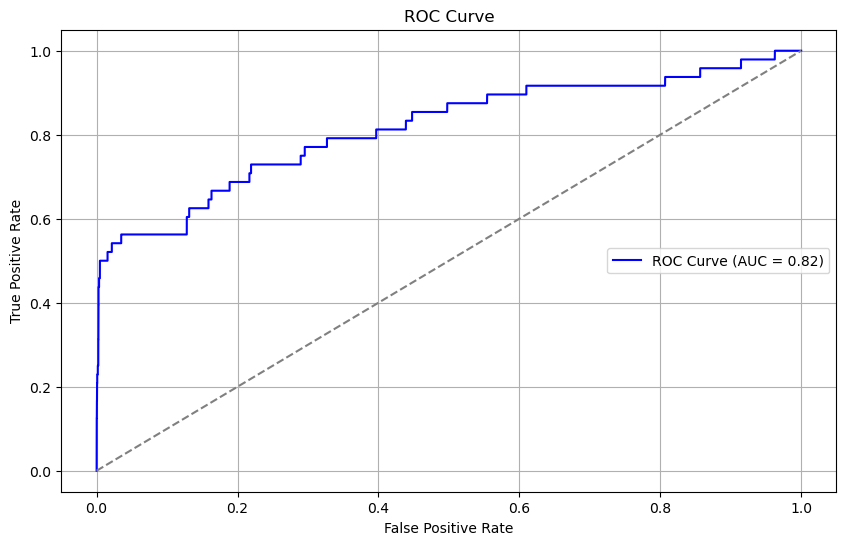

0.8157524948635163

In [17]:
plot_roc_curve(Y_val, val_predictions)

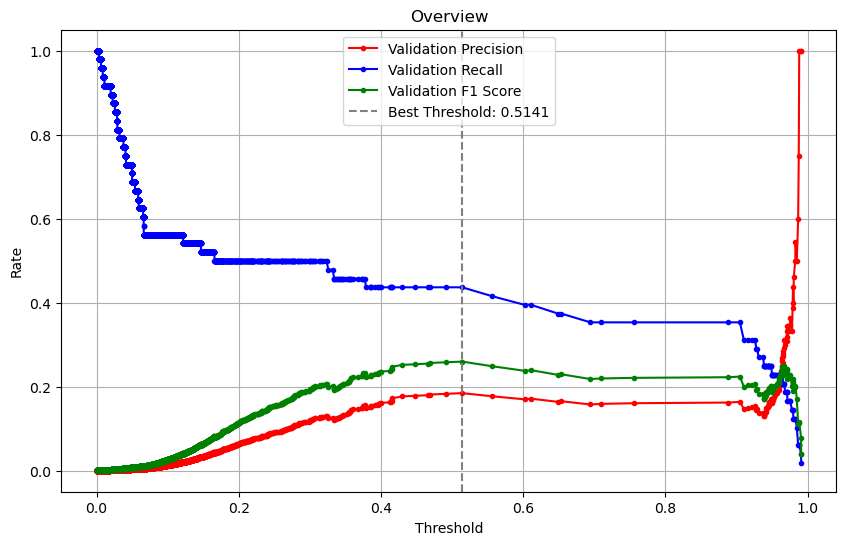

In [18]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)
client.log_param(parent_run_id, 'best_threshold', best_threshold)
client.set_model_version_tag(
    name=model_name,
    version=challenger.version,
    key="best_threshold",
    value=str(best_threshold)
)

In [19]:
# Predict on the test set
test_predictions = loaded_model.predict_proba(X_test)[:, 1]

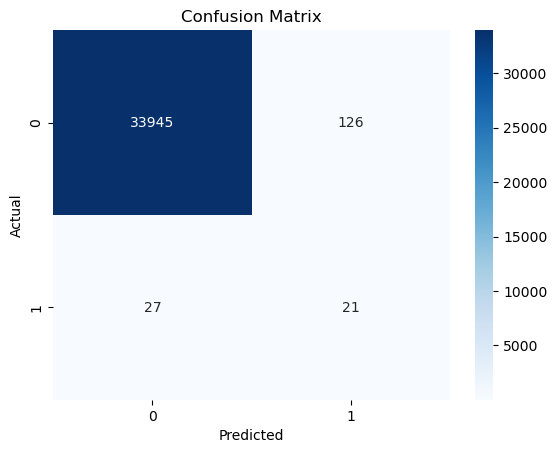

Accuracy     = 1.0
Recall       = 0.44
Precision    = 0.14
F1           = 0.22


In [20]:
challenger_result = get_result(Y_test, test_predictions, best_threshold, visualize=True)

Lets see if it's better than the current champion model (if this is not the first time running)

In [21]:
challenge_champion(
    client, 
    algorithm_name = 'randomforest',
    model_name = model_name, 
    X_test = X_test,
    Y_test = Y_test, 
    challenger_metrics = challenger_result, 
    competing_metric = 'f1'
)

No existing champion model found.
Setting current model as champion.


### Train on both training and validation set

Training the previous model we did not use the validation set, which contains 10% of the original dataset. It could be interresting to see if the model, with the same parameters, could perform better on the test set if it had more data to train on. We'll keep the best threshold, since the model now have seen the data to construct the best threshold and thus be more sure than wants best in general.

Lets merge the training and validation set and predict on the test set again.

In [22]:
best_run = mlflow.get_run(parent_run_id)
best_params = best_run.data.params
best_params = {k: auto_cast(v) for k, v in best_params.items()}
best_params

{'max_depth': 36,
 'n_estimators': 236,
 'min_samples_split': 9,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'bootstrap': False,
 'class_weight': 'balanced',
 'best_threshold': 0.5141148672782515}

In [23]:
# Remove best_threshold from best_params
best_params.pop('best_threshold', None)

0.5141148672782515

In [24]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
rfc = RandomForestClassifier(**best_params)

In [25]:
# Train the model
rfc.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=36,
                       min_samples_leaf=10, min_samples_split=9,
                       n_estimators=236)

In [26]:
# Predict on the val set
val_predictions = rfc.predict_proba(X_val)[:, 1]

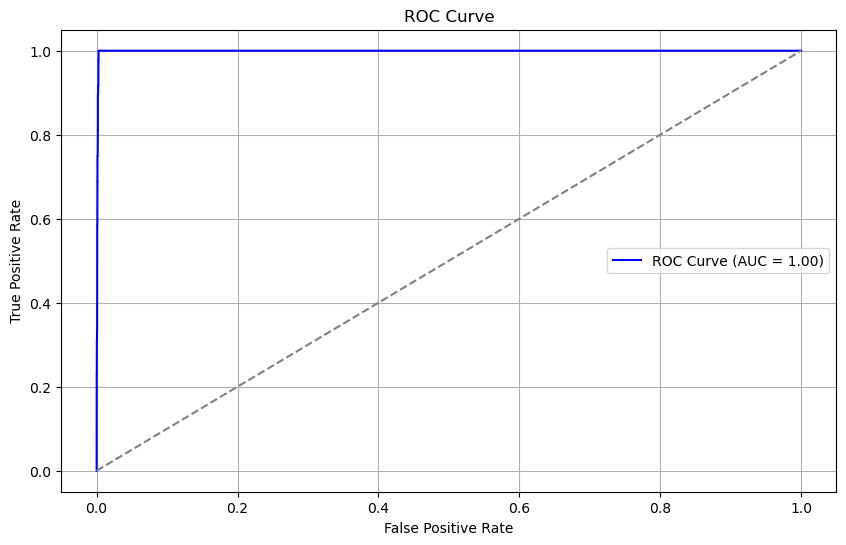

0.9990729869875746

In [27]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

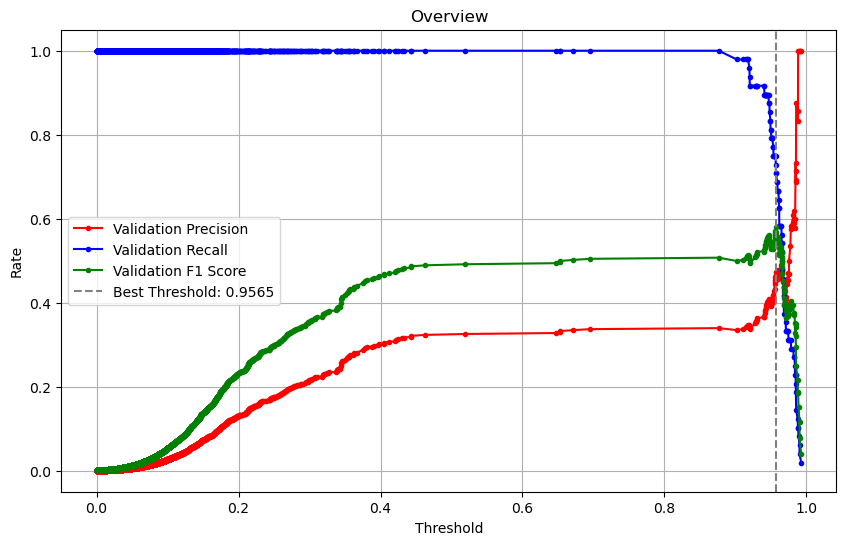

In [28]:
_ = get_best_threshold('Validation', Y_val, val_predictions)

In [29]:
# Predict on the test set
test_predictions = rfc.predict_proba(X_test)[:, 1]

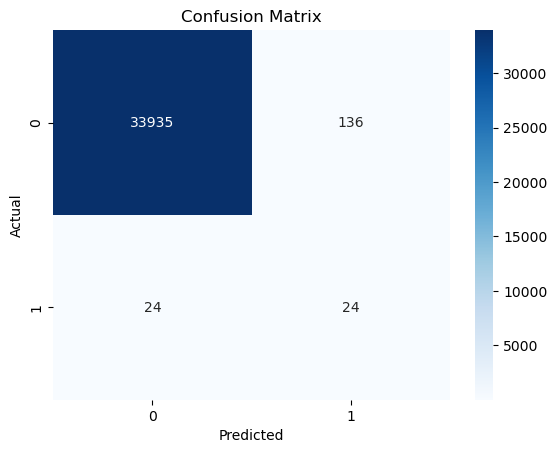

Accuracy     = 1.0
Recall       = 0.5
Precision    = 0.15
F1           = 0.23


In [30]:
result_2 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

In [31]:
if result_2['f1'] > challenger_result['f1']:
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(challenger_result['recall'], 2))
    print('Precision    =', round(challenger_result['precision'], 2))
    print('F1           =', round(challenger_result['f1'], 2))

By training our model on more data, we achived a higher performance on the F1 score
